In [15]:
import gc
import csv
import numpy as np
import matplotlib.pyplot as plt
from models import baseline, gradient_descent
from preprocessing import (features_expansion, features_selection,
                                    get_initial_df, preparation, splitting)
from visualization import snr_plot, y_compare

In [2]:
OUTPUT_FILE = "results.csv"

In [3]:
df_spectra, df_measures, df_tts = get_initial_df('data')
meta_cols = ['SiteCode', 'Date', 'flag',
             'Latitude', 'Longitude']
unc_col = 'DUSTf:Unc'
y_col = 'DUSTf:Value'

In [4]:
merged = preparation(df_spectra, df_measures, meta_cols, unc_col, y_col)
%xdel df_spectra
%xdel df_measures
print("Shape: merged: {}".format(merged.shape))

Shape: merged: (18001, 2791)


In [5]:
tx_train, y_train, _, tx_test, y_test, unc_test = splitting(merged,df_tts,meta_cols,unc_col,y_col)
print("Shapes:\n\ttx_train: {}\n\ty_train: {}\n\ttx_test: {}\n\ty_test: {}".format(tx_train.shape, y_train.shape, tx_test.shape, y_test.shape))
%xdel merged
%xdel df_tts

Shapes:
	tx_train: (13357, 2784)
	y_train: (13357,)
	tx_test: (4644, 2784)
	y_test: (4644,)


In [6]:
gd_initial_weights = np.random.rand(tx_train.shape[1])
print(gd_initial_weights.shape)

(2784,)


In [7]:
with open(OUTPUT_FILE, "w") as f:
    writer = csv.writer(f)
    writer.writerow(["methos", 'w', 'loss'])

# Methods

## BASELINE

	loss of 0.6638077119752045


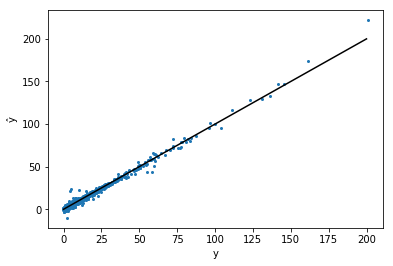

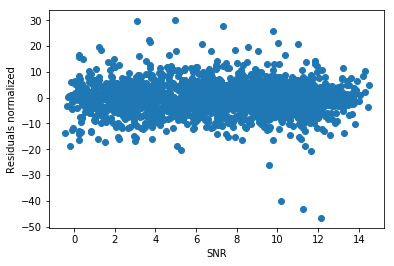

In [12]:
loss, weights_baseline = baseline(tx_train, y_train, tx_test, y_test, OUTPUT_FILE)
print("\tloss of {}".format(loss))
y_compare(tx_test, y_test, weights_baseline, "baseline_y-compare_simple.png")
snr_plot(tx_test, y_test, weights_baseline, unc_test, "baseline_snr_simple.png")

Iteration 0, loss is 1419.779174440148
Iteration 100, loss is 86.0165895726155
Iteration 200, loss is 51.36222066798355
Iteration 300, loss is 41.161616380021464
Iteration 326, loss was 39.664014355406835, now is 39.675463380674984, diff = -0.011449025268149171


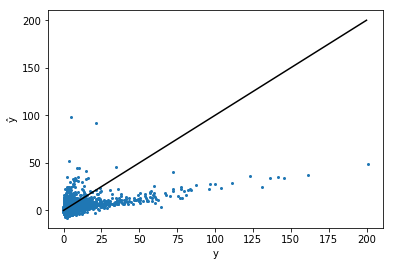

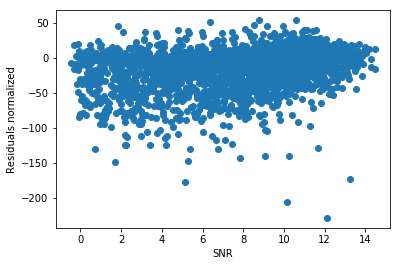

In [13]:
loss, weights_sgd = gradient_descent(tx_train, y_train, gd_initial_weights, 1000, 0.005)
y_compare(tx_test, y_test, weights_sgd, "GD_y-compare_simple.png")
snr_plot(tx_test, y_test, weights_sgd, unc_test, "GD_snr_simple.png")

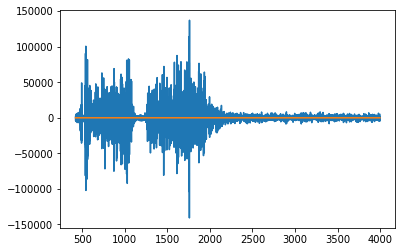

In [30]:
plt.plot(tx_train.columns, weights_baseline)
plt.plot(tx_train.columns, weights_sgd)
# plt.yscale('log')
plt.show()

## Least-Squares with Cross-validation

In [ ]:
# for ind_tr, ind_te in kf.split(X):
# #             print(y.iloc[ind_tr].values)
#             loss_tr, loss_te, w = (X.iloc[ind_tr].values, 
#                                                   y.iloc[ind_tr].values,
#                                                   X.iloc[ind_te].values,
#                                                   y.iloc[ind_te].values, 
#                                                   lambda_,)

In [26]:
def cross_validation_demo():
#     seed = 12
    k_fold = 10
    lambdas = np.logspace(-7, -3, 30)
    # define lists to store the loss of training data and test data
    rmse_tr = []
    rmse_te = []
    # cross validation
    
    for lambda_ in lambdas:
        print('lambda=',lambda_)
        rmse_tr_tmp = []
        rmse_te_tmp = []
        kf = KFold(n_splits=k_fold, shuffle=True)
        
        for ind_tr, ind_te in kf.split(X):
#             print(y.iloc[ind_tr].values)
            loss_tr, loss_te, w = cross_validation(X.iloc[ind_tr].values, 
                                                  y.iloc[ind_tr].values,
                                                  X.iloc[ind_te].values,
                                                  y.iloc[ind_te].values, 
                                                  lambda_,)
            print("Losses are [tr]:{:.4f}, [te]:{:.5f}".format(loss_tr, loss_te))
            rmse_tr_tmp.append(loss_tr)
            rmse_te_tmp.append(loss_te)
        rmse_tr.append(np.mean(rmse_tr_tmp))
        rmse_te.append(np.mean(rmse_te_tmp))
    return lambdas, rmse_tr, rmse_te

# lambdas, rmse_tr, rmse_te = cross_validation_demo()
# cross_validation_visualization(lambdas, rmse_tr, rmse_te)
# cross_validation_visualization(lambdas[:15], rmse_tr[:15], rmse_te[:15])